In [1]:
# Import required libaries 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
import wget 
import os 
import pandas as pd
import numpy as np 

# Data Extraction

In [2]:
# Create dataframe from CSV 

imagery_df = pd.read_csv('basic_good_image_set.csv')
imagery_df = imagery_df.fillna('None')
print(imagery_df.dtypes)
print(imagery_df)

Year                       int64
Month                      int64
Day                        int64
Cloudiness                object
Greenness                 object
Estimated Usability       object
Area Estimate              int64
Top Right Latitude       float64
Top Right Longitude      float64
Bottom Left Latitude     float64
Bottom Left Longitude    float64
Image Filename            object
URL                       object
dtype: object
    Year  Month  Day Cloudiness    Greenness Estimated Usability  \
0   2024      7    8       None         High                High   
1   2023      7   23       None         High                High   
2   2022      7   24       None         High                High   
3   2021      7    1       None  Medium-High         Medium-High   
4   2020      7   27       None         High                High   
5   2019      7   23       None         High                High   
6   2018      7   16       None         High                High   
7   2017     

In [3]:
# Download files, should ONLY download if they are not already in to directory 
# Source of directory read technique: https://www.geeksforgeeks.org/python/python-list-files-in-a-directory/
# If we need to do any os related things you can grab os from: https://www.google.com/search?q=get+os+version+python&sca_esv=7a3339a54e4f1566&ei=Y0EWaevMCJaA0PEPhtjtmQw&ved=0ahUKEwiriuy5_e-QAxUWADQIHQZsO8MQ4dUDCBE&uact=5&oq=get+os+version+python&gs_lp=Egxnd3Mtd2l6LXNlcnAiFWdldCBvcyB2ZXJzaW9uIHB5dGhvbjIFEAAYgAQyBhAAGBYYHjIGEAAYFhgeMggQABiABBiiBDIFEAAY7wUyBRAAGO8FSLZXUMYPWKBWcAN4AZABAJgBjAGgAcYOqgEEMTkuMrgBA8gBAPgBAZgCGKACtA_CAgoQABiwAxjWBBhHwgILEAAYgAQYkQIYigXCAhAQABiABBixAxhDGIMBGIoFwgIWEC4YgAQYsQMY0QMYQxiDARjHARiKBcICEBAuGIAEGNEDGEMYxwEYigXCAgoQABiABBhDGIoFwgIKEC4YgAQYQxiKBcICCxAuGIAEGMcBGK8BwgIOEC4YgAQYsQMYgwEY1ALCAg4QABiABBixAxiDARiKBcICBRAuGIAEwgIIEC4YgAQYsQPCAgQQABgDwgIOEC4YgAQYsQMY0QMYxwHCAg0QABiABBixAxhDGIoFwgINEC4YgAQYsQMYQxiKBcICCxAuGIAEGLEDGNQCwgILEAAYgAQYsQMYgwHCAggQABiABBixA8ICCxAuGIAEGLEDGIMBwgIcEC4YgAQYsQMYQxiKBRiXBRjcBBjeBBjgBNgBAcICCxAAGIAEGIYDGIoFmAMAiAYBkAYIugYGCAEQARgUkgcEMTguNqAH6aABsgcEMTUuNrgHqQ_CBwcwLjExLjEzyAdS&sclient=gws-wiz-serp

# Select the path you want to evaluate, the only dataset currently is the basic known good image set 
path = './city_images/raw/basic_good_image_set' 

dir_list = os.listdir(path)

for i in range(len(imagery_df)):
    image_fn = imagery_df['Image Filename'][i]
    if not image_fn in dir_list:
        print('Image not already in folder, downloading...')
        image = wget.download(imagery_df['URL'][i],path+image_fn)
    else:
        print('Image already in image folder')

Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder


# Image Cleaning

In [4]:
# Only select images that do not have clouds and are in summer months, this will be more complicated if we don't manually label the cloudy data 
print(f'Total length of precleaned dataset: {len(imagery_df)}') 
cleaned_df = imagery_df.query("Month == 7 & Cloudiness.eq('None') & Greenness.eq('High')")
print(f'Total length of cleaned dataset: {len(cleaned_df)}')

for im_fn in cleaned_df['Image Filename']:
    image = cv2.imread('./city_images/raw/basic_good_image_set/'+im_fn)
    cv2.imwrite('./city_images/cleaned/basic_good_image_set/'+im_fn,image)

Total length of precleaned dataset: 24
Total length of cleaned dataset: 20


# Image Processing

In [5]:
# Choose green thresholding values 
# lower_green = np.array([37, 40, 40]) # Hue, Saturation, Value
# upper_green = np.array([85, 255, 255]) 

lower_green = np.array([40, 40, 0]) # Hue, Saturation, Value
upper_green = np.array([85, 255, 255]) 

# Choose greyscale thresholding values 
lower_grey = 0  
upper_grey = 255

# Setup image list 
images_processed = [] 
# Setup loop for processing images 
for im_fn in cleaned_df['Image Filename']:
    image = cv2.imread('./city_images/cleaned/basic_good_image_set/'+im_fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image_mask = cv2.inRange(image, lower_green, upper_green)
    image_inverted_mask = cv2.bitwise_not(image_mask)
    image = cv2.bitwise_and(image, image, mask=image_inverted_mask)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, image_bitmask = cv2.threshold(image, lower_grey, upper_grey, cv2.THRESH_BINARY)
    cv2.imwrite('./city_images/processed/basic_good_image_set/'+im_fn.split('.')[0]+'.bmp',image_bitmask)
# plt.imshow(image) # If you wnat to show an image, cv2.imshow() doesn't work well in notebooks, use plt instead 


# Image Analysis

In [6]:
# Determine distances of image manually 
distance_width = 42 # km - determined from calculator: https://www.nhc.noaa.gov/gccalc.shtml
distance_height = 67 # km - determined from calculator: " 

area_per_year = [] 

for im_fn in cleaned_df['Image Filename']:
    image = cv2.imread('./city_images/processed/basic_good_image_set/'+im_fn.split('.')[0]+'.bmp',cv2.IMREAD_GRAYSCALE)

    # Calculate sq km per pixel 
    pixel_width = 275 
    pixel_height = 275
    sqkmpp = (distance_width*distance_height)/(pixel_height*pixel_width)

    # Calculate area estimate 
    area_estimate = cv2.countNonZero(image)*sqkmpp
    area_per_year.append(area_estimate)

print(area_per_year)

[856.6839272727273, 1415.7257256198347, 1131.6280066115703, 961.9879933884298, 894.6008330578512, 1378.8879074380166, 1305.9192595041322, 713.4629553719009, 1028.9658446280991, 1352.72933553719, 848.2744859504132, 1133.302452892562, 1057.5058512396695, 665.4621619834711, 918.4151801652893, 881.0936330578512, 660.4388231404959, 891.8472991735537, 875.363305785124, 542.8554842975207]


In [7]:

print(len(area_per_year))

20


In [8]:
years = list(cleaned_df['Year'])
manual_area = list(cleaned_df['Area Estimate'])




# Graph Visualization

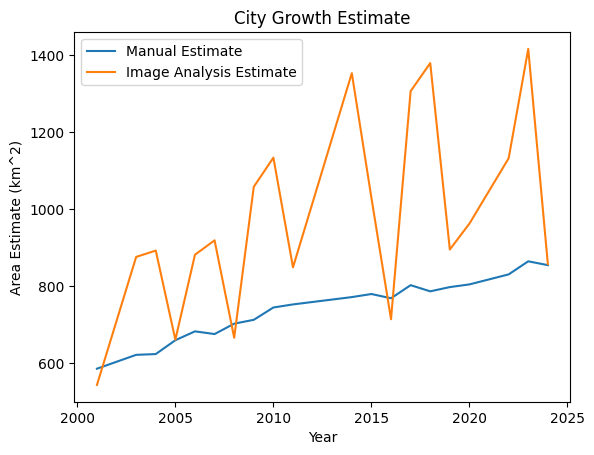

In [9]:
plt.plot(years,manual_area,label='Manual Estimate')
plt.plot(years,area_per_year,label='Image Analysis Estimate')
plt.xlabel('Year')
plt.ylabel('Area Estimate (km^2)')
plt.title('City Growth Estimate')
plt.legend()